True Channel Matrix (H):
 [[ 0.49671415+1.57921282j -0.1382643 +0.76743473j]
 [ 0.64768854-0.46947439j  1.52302986+0.54256004j]
 [-0.23415337-0.46341769j -0.23413696-0.46572975j]]
Estimated Channel Matrix (H_est):
 [[-0.67850317-4.58838120e-18j  0.67111982-9.78854656e-17j]
 [ 0.04601768+6.79405536e-01j -0.05668953+6.92214847e-01j]
 [ 0.24754156-1.21025259e-01j -0.15236818-2.09778535e-01j]]
Mean Squared Error (MSE): 1.6234016873993171


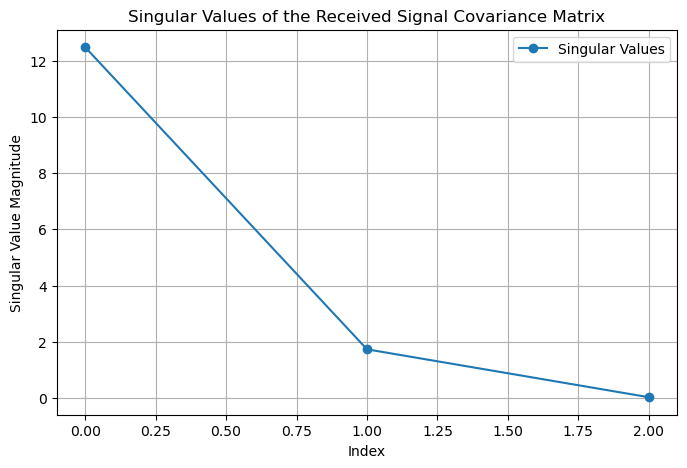

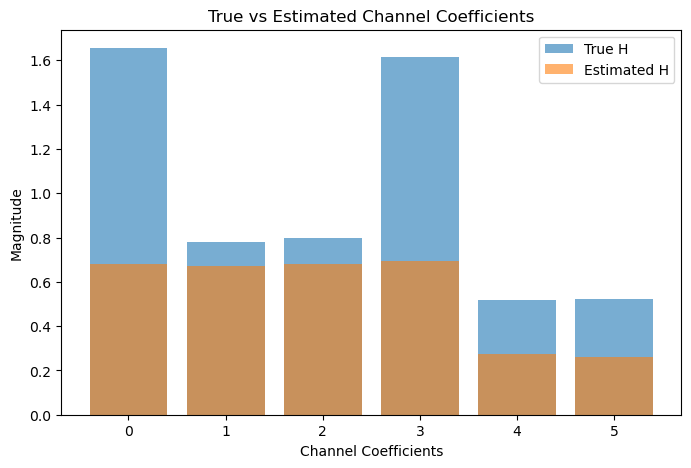

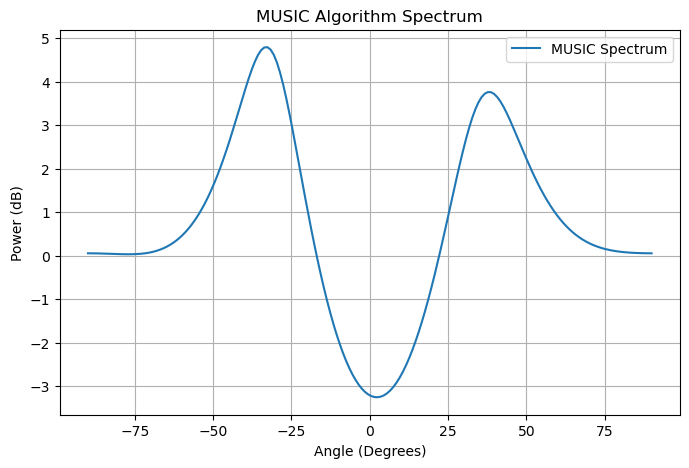

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eigh

def blind_channel_estimation_svd(received_signal, num_tx, num_rx):
    """
    Estimate the channel matrix H using Singular Value Decomposition (SVD).
    
    Parameters:
    received_signal (ndarray): The received signal matrix (num_rx x num_samples).
    num_tx (int): Number of transmitting antennas.
    num_rx (int): Number of receiving antennas.
    
    Returns:
    H_est (ndarray): Estimated channel matrix (num_rx x num_tx).
    """
    # Compute the covariance matrix of received signal
    R = np.dot(received_signal, received_signal.T.conj()) / received_signal.shape[1]
    
    # Perform Singular Value Decomposition
    U, S, Vh = svd(R)
    
    # Estimate the channel matrix using the strongest singular values
    H_est = U[:, :num_tx]  # Taking the first num_tx singular vectors
    
    return H_est, S

def music_spectrum(received_signal, num_tx, num_rx, angles=np.linspace(-90, 90, 180)):
    """
    Compute the MUSIC spectrum for direction of arrival estimation.
    
    Parameters:
    received_signal (ndarray): The received signal matrix (num_rx x num_samples).
    num_tx (int): Number of transmitting antennas.
    num_rx (int): Number of receiving antennas.
    angles (ndarray): Range of angles to scan for signal sources.
    
    Returns:
    spectrum (ndarray): MUSIC spectrum over the given angles.
    """
    # Compute the covariance matrix of received signal
    R = np.dot(received_signal, received_signal.T.conj()) / received_signal.shape[1]
    
    # Eigen decomposition
    eigvals, eigvecs = eigh(R)
    
    # Noise subspace (smallest eigenvectors)
    noise_subspace = eigvecs[:, :-num_tx]
    
    # Compute MUSIC spectrum
    spectrum = []
    for angle in angles:
        steering_vector = np.exp(1j * np.pi * np.arange(num_rx) * np.sin(np.radians(angle)))[:, np.newaxis]
        psd = 1 / np.linalg.norm(noise_subspace.conj().T @ steering_vector) ** 2
        spectrum.append(psd)
    
    return np.array(spectrum), angles

# Example Usage
if __name__ == "__main__":
    np.random.seed(42)
    num_tx = 2  # Number of transmitting antennas
    num_rx = 3  # Number of receiving antennas
    num_samples = 1000  # Number of received samples
    
    # Generate a random channel matrix H (ground truth)
    H_true = np.random.randn(num_rx, num_tx) + 1j * np.random.randn(num_rx, num_tx)
    
    # Generate a random transmitted signal X
    X = np.random.randn(num_tx, num_samples) + 1j * np.random.randn(num_tx, num_samples)
    
    # Simulate received signal Y = H * X + Noise
    noise = 0.1 * (np.random.randn(num_rx, num_samples) + 1j * np.random.randn(num_rx, num_samples))
    received_signal = H_true @ X + noise
    
    # Perform blind channel estimation using SVD
    H_est, singular_values = blind_channel_estimation_svd(received_signal, num_tx, num_rx)
    
    # Compute Mean Squared Error (MSE) between true and estimated H
    mse = np.mean(np.abs(H_true - H_est) ** 2)
    
    print("True Channel Matrix (H):\n", H_true)
    print("Estimated Channel Matrix (H_est):\n", H_est)
    print("Mean Squared Error (MSE):", mse)
    
    # Plot singular values to analyze signal and noise space
    plt.figure(figsize=(8, 5))
    plt.plot(singular_values, 'o-', label='Singular Values')
    plt.xlabel("Index")
    plt.ylabel("Singular Value Magnitude")
    plt.title("Singular Values of the Received Signal Covariance Matrix")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot true vs estimated channel response
    plt.figure(figsize=(8, 5))
    plt.bar(range(num_rx * num_tx), np.abs(H_true.flatten()), alpha=0.6, label='True H')
    plt.bar(range(num_rx * num_tx), np.abs(H_est.flatten()), alpha=0.6, label='Estimated H')
    plt.xlabel("Channel Coefficients")
    plt.ylabel("Magnitude")
    plt.title("True vs Estimated Channel Coefficients")
    plt.legend()
    plt.show()
    
    # Compute MUSIC spectrum
    spectrum, angles = music_spectrum(received_signal, num_tx, num_rx)
    
    # Plot MUSIC spectrum
    plt.figure(figsize=(8, 5))
    plt.plot(angles, 10 * np.log10(spectrum), label='MUSIC Spectrum')
    plt.xlabel("Angle (Degrees)")
    plt.ylabel("Power (dB)")
    plt.title("MUSIC Algorithm Spectrum")
    plt.legend()
    plt.grid()
    plt.show()
